# Setup

In [1]:
import pickle
import numpy as np
import pandas as pd
import prince
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, auc
from scipy.spatial.distance import hamming

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm, trange

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family'] = 'sans-serif'
sns.set_style('ticks')
matplotlib.rcParams['text.color'] = '#000000'
matplotlib.rcParams['axes.labelcolor'] = '#000000'
matplotlib.rcParams['xtick.color'] = '#000000'
matplotlib.rcParams['ytick.color'] = '#000000'

In [2]:
# # Annotated L_bin and A_bin matrices
# L_bin = pd.read_csv('../../data/processed/nmf-outputs/L_binarized.csv', index_col=0)
# A_bin = pd.read_csv('../../data/processed/nmf-outputs/A_binarized.csv', index_col=0)

# display(
#     'L_bin',
#     L_bin.shape,
#     L_bin.head(),
#     'A_bin',
#     A_bin.shape,
#     A_bin.head()
# )

# MCA (for rank analysis)

In [3]:
# Step 1: Read the data
P_complete = pd.read_pickle('../../data/processed/CAR_genomes/df_acc_complete.pickle')

display(
    P_complete.shape,
    P_complete.head(),
    P_complete.dtypes
)

(4889, 473)

,158836.809,550.1141,1686399.7,1296536.241,550.3830,1812935.464,1333851.3,208224.404,158836.2021,158836.2356,...,158836.801,550.2813,158836.2201,550.2254,299766.198,1045856.3,299766.187,158836.1100,299766.116,158836.2022
Ebacter_C15853,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Ebacter_C51247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Ebacter_C100996,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
Ebacter_C20249,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Ebacter_C95262,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0


158836.809     int8
550.1141       int8
1686399.7      int8
1296536.241    int8
550.3830       int8
               ... 
1045856.3      int8
299766.187     int8
158836.1100    int8
299766.116     int8
158836.2022    int8
Length: 473, dtype: object

In [4]:
# Step 2: Perform MCA with prince (run once)
mca = prince.MCA(
    n_components=4889,  # Set the number of components
    n_iter=3,           # Set the number of iterations for the CA algorithm
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(P_complete)  # Fit MCA on the dataframe

mca

MCA(n_components=4889, n_iter=3, random_state=42)

In [5]:
# Save mca model for future use
with open('mca_model.pickle', 'wb') as f:
    pickle.dump(mca, f)

In [6]:
# Step 2: Load in MCA model
with open('mca_model.pickle', 'rb') as f:
    mca = pickle.load(f)

mca

MCA(n_components=4889, n_iter=3, random_state=42)

In [7]:
# Step 3: Extract and plot the cumulative explained variance
explained_variance_percentage = mca.percentage_of_variance_  # Retrieve explained inertia which gives variance explained by each component
cumulative_variance = pd.Series(explained_variance_percentage).cumsum()  # Cumulative sum to find cumulative explained variance

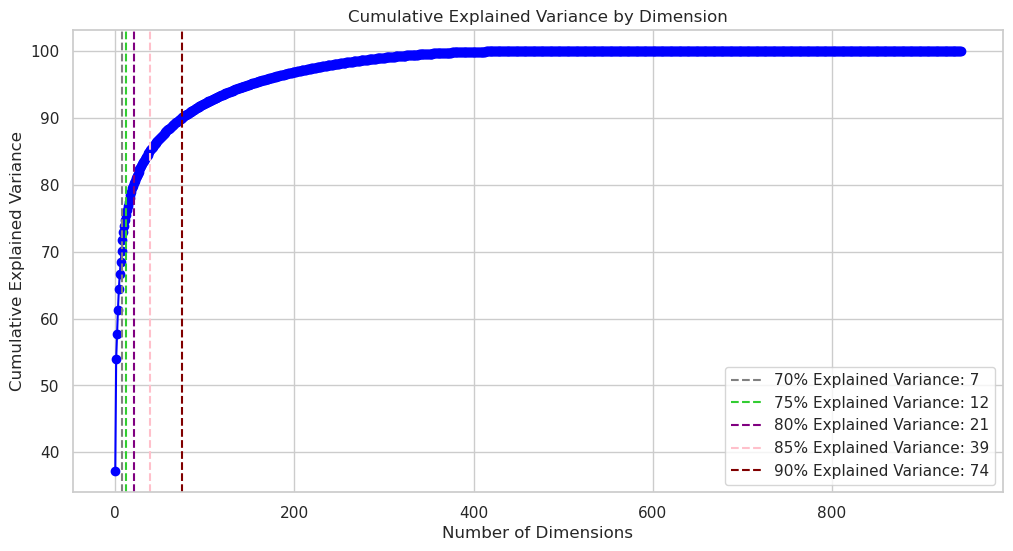

In [8]:
# Create the plot (full)
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-', color='blue')
plt.title('Cumulative Explained Variance by Dimension')
plt.xlabel('Number of Dimensions')
plt.ylabel('Cumulative Explained Variance')

# Calculate explained inertia (variance) thresholds
threshold = {num: cumulative_variance[cumulative_variance >= num].index[0] for num in range(1,99)}

# Add vertical lines for explained inertia thresholds
plt.axvline(x=threshold[70], color='grey', label=f'70% Explained Variance: {threshold[70]}', linestyle='--')
plt.axvline(x=threshold[75], color='limegreen', label=f'75% Explained Variance: {threshold[75]}', linestyle='--')
plt.axvline(x=threshold[80], color='purple', label=f'80% Explained Variance: {threshold[80]}', linestyle='--')
plt.axvline(x=threshold[85], color='pink', label=f'85% Explained Variance: {threshold[85]}', linestyle='--')
plt.axvline(x=threshold[90], color='maroon', label=f'90% Explained Variance: {threshold[90]}', linestyle='--')

plt.legend()
plt.show()

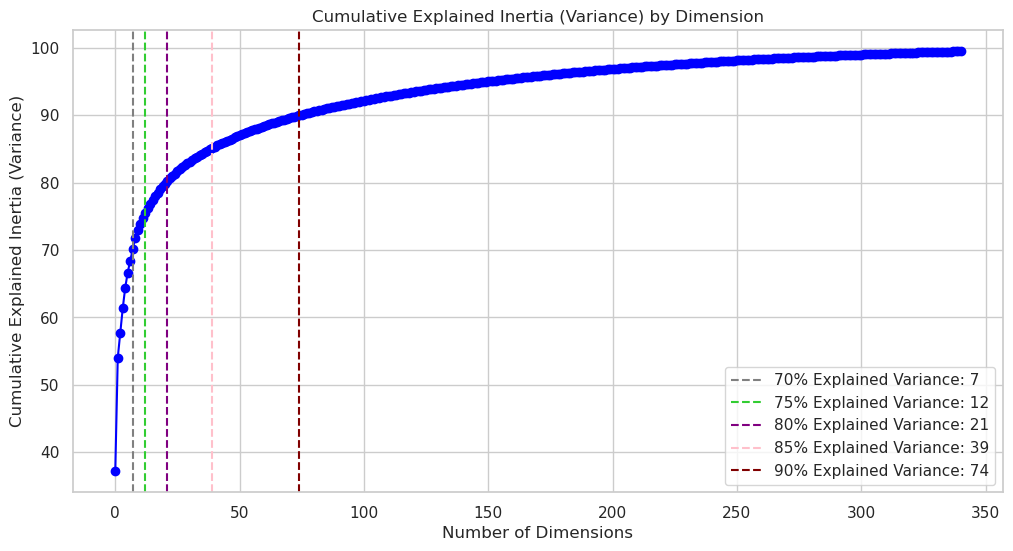

In [9]:
# Create the plot (first n components)
n_significant_components = (explained_variance_percentage > 0.01).sum()

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(cumulative_variance[:n_significant_components], marker='o', linestyle='-', color='blue')
plt.title('Cumulative Explained Inertia (Variance) by Dimension')
plt.xlabel('Number of Dimensions')
plt.ylabel('Cumulative Explained Inertia (Variance)')

# Add vertical lines for explained inertia thresholds
plt.axvline(x=threshold[70], color='grey', label=f'70% Explained Variance: {threshold[70]}', linestyle='--')
plt.axvline(x=threshold[75], color='limegreen', label=f'75% Explained Variance: {threshold[75]}', linestyle='--')
plt.axvline(x=threshold[80], color='purple', label=f'80% Explained Variance: {threshold[80]}', linestyle='--')
plt.axvline(x=threshold[85], color='pink', label=f'85% Explained Variance: {threshold[85]}', linestyle='--')
plt.axvline(x=threshold[90], color='maroon', label=f'90% Explained Variance: {threshold[90]}', linestyle='--')

plt.legend()
plt.show()

* take the genes in a phylogroup and plot CDF histogram (to see distribution of genes in a phylogroup)
* see if they overlap with poor-performing genes

# NMF at various ranks (determined by MCA)

In [10]:
mash_rank = 21 # Calculated from Mash analysis

In [11]:
# Explore ranks up to 90% explained variance in MCA, including the 10 ranks surrouding the optimal mash cluster value
rank_list = sorted(set([2, threshold[70], threshold[75], threshold[80], threshold[85], threshold[90]] + 
                       list(range(mash_rank - 2, mash_rank + 3))))
rank_list = sorted(set([2, threshold[70], threshold[75], threshold[80], threshold[85], threshold[90]] + 
                       list(range(mash_rank - 4, mash_rank + 6))))
rank_list

[2, 7, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 39, 74]

In [12]:
# Dictionaries to store the best W and H matrices
W_dict = {}
H_dict = {}

# Perform NMF for each rank in rank_list
for rank in tqdm(rank_list, desc='Running NMF at varying ranks...'):
    best_reconstruction_error = np.inf
    best_W = None
    best_H = None

    # Run NMF three times with different random states
    for random_state in tqdm([1, 2, 3], leave=False, desc='NMF run at random state'):
        model = NMF(n_components=rank, init='nndsvd', max_iter=5_000, random_state=random_state)
        W = model.fit_transform(P_complete)
        H = model.components_
        reconstruction = np.dot(W, H)
        error = np.linalg.norm(P_complete - reconstruction, 'fro')  # Calculate the Frobenius norm of the difference

        # Update the best W and H matrices if the current model has a lower reconstruction error
        if error < best_reconstruction_error:
            best_reconstruction_error = error
            best_W = W
            best_H = H

    # Store the best W and H matrices in the dictionaries with the rank as the key
    W_dict[rank] = best_W
    H_dict[rank] = best_H

# At this point, W_dict and H_dict hold the best W and H matrices for each rank


Running NMF at varying ranks...:   0%|          | 0/15 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
# Save W_dict and H_dict for future use
with open('W_dict.pickle', 'wb') as f1:
    pickle.dump(W_dict, f1)

with open('H_dict.pickle', 'wb') as f2:
    pickle.dump(H_dict, f2)

In [14]:
# Read in saved W_dict and H_dict
with open('W_dict.pickle', 'rb') as f1:
    W_dict = pickle.load(f1)

with open('H_dict.pickle', 'rb') as f2:
    H_dict = pickle.load(f2)

# NMF rank analysis (via P - L<sub>bin</sub> * A<sub>bin</sub> )

## Useful functions

In [15]:
# Generate normalization matrices (to normalize W and H matrices into L and A)
def get_normalization_diagonals(L):
    normalization_vals = [1/np.quantile(L[col], q=0.99) for col in L.columns]
    recipricol_vals = [1/x for x in normalization_vals]
    
    D1 = np.diag(normalization_vals)
    D2 = np.diag(recipricol_vals)
    
    return D1, D2

In [16]:
# Use k-means clustering (k=3) to binarize L_norm and A_norm matrices
def k_means_binarize_L(L_norm):
    
    # Initialize an empty array to hold the binarized matrix
    L_binarized = np.zeros_like(L_norm.values)
    
    # Loop through each column
    for col_idx in trange(L_norm.values.shape[1], leave=False, desc='looping column by column...'):
        column_data = L_norm.values[:, col_idx]
    
        # Reshape the column data to fit the KMeans input shape
        column_data_reshaped = column_data.reshape(-1, 1)
    
        # Apply 3-means clustering (generally better precision-recall tradeoff than 2-means)
        kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
        kmeans.fit(column_data_reshaped)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
    
        # Find the cluster with the highest mean
        highest_mean_cluster = np.argmax(centers)
    
        # Binarize the column based on the cluster with the highest mean
        binarized_column = (labels == highest_mean_cluster).astype(int)
    
        # Update the binarized matrix
        L_binarized[:, col_idx] = binarized_column
    
    # Typecast to DataFrame
    L_binarized = pd.DataFrame(L_binarized, index=L_norm.index, columns=L_norm.columns)
    return L_binarized


def k_means_binarize_A(A_norm):
    # Initialize an empty array to hold the binarized matrix
    A_binarized = np.zeros_like(A_norm.values)
    
    # Loop through each row
    for row_idx in trange(A_norm.values.shape[0], leave=False, desc='looping row by row...'):
        row_data = A_norm.values[row_idx, :]
    
        # Reshape the row data to fit the KMeans input shape
        row_data_reshaped = row_data.reshape(-1, 1)
    
        # Apply 3-means clustering (generally better precision-recall tradeoff than 2-means)
        kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
        kmeans.fit(row_data_reshaped)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
    
        # Find the cluster with the highest mean
        highest_mean_cluster = np.argmax(centers)
    
        # Binarize the row based on the cluster with the highest mean
        binarized_row = (labels == highest_mean_cluster).astype(int)
    
        # Update the binarized matrix
        A_binarized[row_idx, :] = binarized_row
    
    # Typecast to DataFrame
    A_binarized = pd.DataFrame(A_binarized, index=A_norm.index, columns=A_norm.columns)
    return A_binarized



In [17]:
# Model evaluation and metrics

def evaluate_model_reconstruction(P_complete, L_binarized, A_binarized):
    
    # Multiply the binarized matrices to get the reconstructed matrix
    P_reconstructed = pd.DataFrame(
        np.dot(L_binarized, A_binarized),
        index=P_complete.index,
        columns=P_complete.columns
    )
    
    # Calculate the error matrix
    P_error = P_complete - P_reconstructed
    
    # Binarize the original and reconstructed matrices for confusion matrix calculation
    P_complete_binary = (P_complete.values > 0).astype(int)
    P_reconstructed_binary = (P_reconstructed.values > 0).astype(int)
    
    # Flatten the matrices to use them in the confusion matrix calculation
    P_complete_flat = P_complete_binary.flatten()
    P_reconstructed_flat = P_reconstructed_binary.flatten()
    
    # Generate the confusion matrix
    # Definitions:
    # True Positive (TP): both actual and predicted are true
    # False Positive (FP): actual is false, but predicted is true
    # True Negative (TN): both actual and predicted are false
    # False Negative (FN): actual is true, but predicted is false
    P_confusion = confusion_matrix(P_complete_flat, P_reconstructed_flat, labels=[1, 0])
    
    return P_reconstructed, P_error, P_confusion


def calculate_metrics(P_confusion, n_components, P_complete):
    
    # Unpack confusion matrix elements
    TP = P_confusion[0, 0]
    FN = P_confusion[0, 1]
    FP = P_confusion[1, 0]
    TN = P_confusion[1, 1]
    
    # Use float for calculations to prevent integer overflow
    TP, FN, FP, TN = map(float, [TP, FN, FP, TN])
    
    # Calculations
    Precision = TP / (TP + FP) if TP + FP != 0 else 0
    Recall = TP / (TP + FN) if TP + FN != 0 else 0
    FPR = FP / (FP + TN) if FP + TN != 0 else 0
    FNR = FN / (TP + FN) if TP + FN != 0 else 0
    Specificity = TN / (TN + FP) if TN + FP != 0 else 0
    Prevalence = (TP + FN) / (TP + TN + FP + FN)
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    F1_score = 2 * (Precision * Recall) / (Precision + Recall) if Precision + Recall != 0 else 0
    BM = Recall + Specificity - 1

    # Adjusted MCC calculation to avoid overflow
    numerator = TP * TN - FP * FN
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCC = numerator / denominator if denominator != 0 else 0

    Jaccard_index = TP / (TP + FP + FN) if TP + FP + FN != 0 else 0
    Prevalence_Threshold = (np.sqrt(Recall * (1 - Specificity)) + Specificity - 1) / (Recall + Specificity - 1) if Recall + Specificity - 1 != 0 else 0

        
     # Calculate AIC and BIC
    Reconstruction_error = 1 - Jaccard_index
    data_shape = P_complete.shape
    k = 2 * n_components * (data_shape[0] + data_shape[1])  # number of parameters in NMF (W and H matrices)
    Total = TP + TN + FP + FN
    AIC = 2 * k + 2 * Reconstruction_error * Total
    BIC = np.log(Total) * k + 2 * Reconstruction_error * Total
    return {
        'Precision': Precision,
        'Recall': Recall,
        'FPR': FPR,
        'FNR': FNR,
        'Specificity': Specificity,
        'Prevalence': Prevalence,
        'Accuracy': Accuracy,
        'F1 Score': F1_score,
        'BM': BM,
        'Prevalence Threshold': Prevalence_Threshold,
        'MCC': MCC,
        'Jaccard Index': Jaccard_index,
        'AIC': AIC,
        'BIC': BIC
    }

# Example usage:
# P_confusion = np.array([[100, 10], [20, 70]])  # Example confusion matrix
# results = calculate_metrics(P_confusion)
# print(results)

In [18]:
# Utility functions

def find_closest_ranks_to_metric(df_metrics, metric='Accuracy'):
    # Find the rank with the maximum accuracy
    max_accuracy_rank = df_metrics[metric].idxmax()

    # Get all ranks
    all_ranks = df_metrics.index.tolist()

    # Sort ranks just in case
    all_ranks.sort()

    # Find ranks directly before and after the max_accuracy_rank
    higher_rank = None
    lower_rank = None

    # Find the position of the max_accuracy_rank in sorted list
    pos = all_ranks.index(max_accuracy_rank)

    # Check if there's a higher rank available
    if pos + 1 < len(all_ranks):
        higher_rank = all_ranks[pos + 1]

    # Check if there's a lower rank available
    if pos - 1 >= 0:
        lower_rank = all_ranks[pos - 1]

    return lower_rank, max_accuracy_rank, higher_rank


def generate_diff_list(lower_rank, max_acc_rank, higher_rank, rank_list):
    lower_diff = max_acc_rank - lower_rank
    higher_diff = higher_rank - max_acc_rank
    
    if lower_diff < 5:
        lower_diff_list = list(range(lower_rank, max_acc_rank))
    else:
        lower_diff_list = np.linspace(lower_rank, max_acc_rank, 5, dtype='int')
    lower_diff_list = sorted(set(lower_diff_list) - set(rank_list))
    
    if higher_diff < 5:
        higher_diff_list = list(range(max_acc_rank, higher_rank))
    else:
        higher_diff_list = np.linspace(max_acc_rank, higher_rank, 5, dtype='int')
    higher_diff_list = sorted(set(higher_diff_list) - set(rank_list))

    diff_list = lower_diff_list + higher_diff_list
    return diff_list
    

## Rank analysis

In [19]:
# L_norm and A_norm dictionaries
L_norm_dict = {}
A_norm_dict = {}

for rank, matrix in tqdm(W_dict.items(), desc='Normalizing matrices...'):
    D1, D2 = get_normalization_diagonals(pd.DataFrame(matrix))
    
    L_norm_dict[rank] = pd.DataFrame(np.dot(W_dict[rank], D1), index=P_complete.index)
    A_norm_dict[rank] = pd.DataFrame(np.dot(D2, H_dict[rank]), columns=P_complete.columns)

Normalizing matrices...:   0%|          | 0/15 [00:00<?, ?it/s]

In [20]:
# L_bin and A_bin dictionaries
L_binarized_dict = {}
A_binarized_dict = {}

for rank in tqdm(L_norm_dict, desc='Binarizing matrices...'):
    L_binarized_dict[rank] = k_means_binarize_L(L_norm_dict[rank])
    A_binarized_dict[rank] = k_means_binarize_A(A_norm_dict[rank])

Binarizing matrices...:   0%|          | 0/15 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/2 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/2 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/7 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/7 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/12 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/12 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/17 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/17 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/18 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/18 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/19 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/19 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/20 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/20 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/21 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/21 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/22 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/22 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/23 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/23 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/24 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/24 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/25 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/25 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/26 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/26 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/39 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/39 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/74 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/74 [00:00<?, ?it/s]

In [21]:
# Model evaluation dictionaries
P_reconstructed_dict = {}
P_error_dict = {}
P_confusion = {}

for rank in tqdm(L_binarized_dict, desc='Evaluating model reconstructions...'):
    P_reconstructed_dict[rank], P_error_dict[rank], P_confusion[rank] = evaluate_model_reconstruction(
        P_complete,
        L_binarized_dict[rank],
        A_binarized_dict[rank]
    )

Evaluating model reconstructions...:   0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
df_metrics = pd.DataFrame()

for rank in tqdm(P_reconstructed_dict, desc='Tabulating metrics...'):
    df_metrics[rank] = calculate_metrics(P_confusion[rank], rank, P_complete)

df_metrics = df_metrics.T
df_metrics.index.name = 'rank'

df_metrics

Tabulating metrics...:   0%|          | 0/15 [00:00<?, ?it/s]

,Precision,Recall,FPR,FNR,Specificity,Prevalence,Accuracy,F1 Score,BM,Prevalence Threshold,MCC,Jaccard Index,AIC,BIC
rank,,,,,,,,,,,,,,
2,0.922420,0.509164,0.022297,0.490836,0.977703,0.342396,0.817277,0.656145,0.486867,0.173050,0.590089,0.488255,2.409712e+06,2.681111e+06
7,0.944923,0.651876,0.019784,0.348124,0.980216,0.342396,0.867794,0.771509,0.632093,0.148363,0.706141,0.628014,1.870569e+06,2.820467e+06
12,0.950896,0.629115,0.016915,0.370885,0.983085,0.342396,0.861887,0.757239,0.612200,0.140874,0.693993,0.609320,2.064269e+06,3.692666e+06
17,0.951504,0.716354,0.019010,0.283646,0.980990,0.342396,0.890380,0.817352,0.697344,0.140083,0.756491,0.691121,1.793181e+06,4.100077e+06
18,0.951301,0.721710,0.019236,0.278290,0.980764,0.342396,0.892065,0.820752,0.702474,0.140347,0.760158,0.695996,1.792079e+06,4.234674e+06
19,0.954481,0.725288,0.018009,0.274712,0.981991,0.342396,0.894097,0.824249,0.707279,0.136127,0.764959,0.701040,1.790199e+06,4.368495e+06
20,0.955990,0.688896,0.016513,0.311104,0.983487,0.342396,0.882620,0.800758,0.672383,0.134066,0.740073,0.667720,1.965754e+06,4.679749e+06
21,0.957338,0.684466,0.015881,0.315534,0.984119,0.342396,0.881519,0.798226,0.668584,0.132189,0.737844,0.664206,2.003453e+06,4.853148e+06
22,0.958845,0.678959,0.015173,0.321041,0.984827,0.342396,0.880099,0.794987,0.663786,0.130050,0.734949,0.659733,2.045587e+06,5.030982e+06


In [23]:
df_metrics.sort_values('AIC')

,Precision,Recall,FPR,FNR,Specificity,Prevalence,Accuracy,F1 Score,BM,Prevalence Threshold,MCC,Jaccard Index,AIC,BIC
rank,,,,,,,,,,,,,,
19,0.954481,0.725288,0.018009,0.274712,0.981991,0.342396,0.894097,0.824249,0.707279,0.136127,0.764959,0.701040,1.790199e+06,4.368495e+06
18,0.951301,0.721710,0.019236,0.278290,0.980764,0.342396,0.892065,0.820752,0.702474,0.140347,0.760158,0.695996,1.792079e+06,4.234674e+06
17,0.951504,0.716354,0.019010,0.283646,0.980990,0.342396,0.890380,0.817352,0.697344,0.140083,0.756491,0.691121,1.793181e+06,4.100077e+06
7,0.944923,0.651876,0.019784,0.348124,0.980216,0.342396,0.867794,0.771509,0.632093,0.148363,0.706141,0.628014,1.870569e+06,2.820467e+06
20,0.955990,0.688896,0.016513,0.311104,0.983487,0.342396,0.882620,0.800758,0.672383,0.134066,0.740073,0.667720,1.965754e+06,4.679749e+06
21,0.957338,0.684466,0.015881,0.315534,0.984119,0.342396,0.881519,0.798226,0.668584,0.132189,0.737844,0.664206,2.003453e+06,4.853148e+06
22,0.958845,0.678959,0.015173,0.321041,0.984827,0.342396,0.880099,0.794987,0.663786,0.130050,0.734949,0.659733,2.045587e+06,5.030982e+06
12,0.950896,0.629115,0.016915,0.370885,0.983085,0.342396,0.861887,0.757239,0.612200,0.140874,0.693993,0.609320,2.064269e+06,3.692666e+06
23,0.960682,0.668427,0.014244,0.331573,0.985756,0.342396,0.877104,0.788340,0.654183,0.127383,0.728674,0.650628,2.109147e+06,5.230242e+06


## Plots

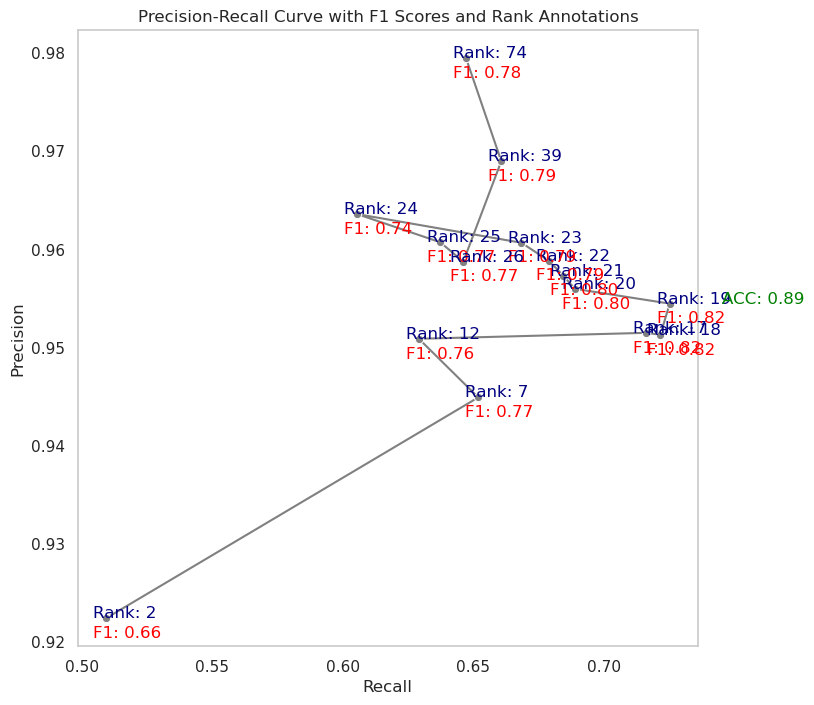

In [24]:
# Sort DataFrame by Rank to ensure lines connect in the correct order
df_metrics.sort_index(inplace=True)

# Set style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 8))
plot = sns.lineplot(x='Recall', y='Precision', data=df_metrics, sort=False, marker='o', linestyle='-', color='grey')

# Annotate each point with rank and F1 Score
for rank, row in df_metrics.iterrows():
    #plt.text(row['Recall'] + 0.01, row['Precision'], f'Rank: {rank}, F1: {row["F1 Score"]:.2f}', color='black')
    plt.text(row['Recall'] - 0.005, row['Precision'], f'Rank: {rank}', color='navy')
    plt.text(row['Recall'] - 0.005, row['Precision'] - 0.002, f'F1: {row["F1 Score"]:.2f}', color='red')
    
    # Annotate the highest accuracy value
    if rank == df_metrics.Accuracy.idxmax():
        plt.text(row['Recall'] + 0.005*4, row['Precision'], f'ACC: {df_metrics.Accuracy.max():.2f}', color='green')

# Plot labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with F1 Scores and Rank Annotations')
plt.grid(False)
plt.show()


## Repeat with additional ranks nearby most accurate model

This is just to confirm we are selecting the most accurate rank for decomposition

In [25]:
# lower_rank, max_acc_rank, higher_rank = find_closest_ranks_to_metric(df_metrics, metric='Accuracy')

# extra_rank_list = generate_diff_list(lower_rank, max_acc_rank, higher_rank, rank_list)
extra_rank_list = [74]

In [26]:
# Perform NMF for each rank in extra_rank_list
for rank in tqdm(extra_rank_list, desc='Running NMF at extra ranks...'):
    best_reconstruction_error = np.inf
    best_W = None
    best_H = None

    # Run NMF three times with different random states
    for random_state in tqdm([1, 2, 3], leave=False, desc='NMF run at random state'):
        model = NMF(n_components=rank, init='nndsvd', max_iter=5_000, random_state=random_state)
        W = model.fit_transform(P_complete)
        H = model.components_
        reconstruction = np.dot(W, H)
        error = np.linalg.norm(P_complete - reconstruction, 'fro')  # Calculate the Frobenius norm of the difference

        # Update the best W and H matrices if the current model has a lower reconstruction error
        if error < best_reconstruction_error:
            best_reconstruction_error = error
            best_W = W
            best_H = H

    # Store the best W and H matrices in the dictionaries with the rank as the key
    W_dict[rank] = best_W
    H_dict[rank] = best_H

# At this point, W_dict and H_dict hold the best W and H matrices for each extra rank


Running NMF at extra ranks...:   0%|          | 0/1 [00:00<?, ?it/s]

NMF run at random state:   0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
# Update W_dict and H_dict for future use
with open('W_dict.pickle', 'wb') as f1:
    pickle.dump(W_dict, f1)

with open('H_dict.pickle', 'wb') as f2:
    pickle.dump(H_dict, f2)

In [28]:
for rank in tqdm(extra_rank_list, desc='Normalizing matrices...'):
    D1, D2 = get_normalization_diagonals(pd.DataFrame(W_dict[rank]))
    
    L_norm_dict[rank] = pd.DataFrame(np.dot(W_dict[rank], D1), index=P_complete.index)
    A_norm_dict[rank] = pd.DataFrame(np.dot(D2, H_dict[rank]), columns=P_complete.columns)

Normalizing matrices...:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
for rank in tqdm(extra_rank_list, desc='Binarizing matrices...'):
    L_binarized_dict[rank] = k_means_binarize_L(L_norm_dict[rank])
    A_binarized_dict[rank] = k_means_binarize_A(A_norm_dict[rank])

Binarizing matrices...:   0%|          | 0/1 [00:00<?, ?it/s]

looping column by column...:   0%|          | 0/74 [00:00<?, ?it/s]

looping row by row...:   0%|          | 0/74 [00:00<?, ?it/s]

In [30]:
for rank in tqdm(extra_rank_list, desc='Evaluating model reconstructions...'):
    P_reconstructed_dict[rank], P_error_dict[rank], P_confusion[rank] = evaluate_model_reconstruction(
        P_complete,
        L_binarized_dict[rank],
        A_binarized_dict[rank]
    )

Evaluating model reconstructions...:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
df_metrics_extra = pd.DataFrame()

for rank in tqdm(extra_rank_list, desc='Tabulating metrics...'):
    df_metrics_extra[rank] = calculate_metrics(P_confusion[rank], rank, P_complete)

df_metrics_extra = df_metrics_extra.T
df_metrics_extra.index.name = 'rank'

df_metrics = pd.concat([df_metrics, df_metrics_extra]).sort_index()

df_metrics

Tabulating metrics...:   0%|          | 0/1 [00:00<?, ?it/s]

,Precision,Recall,FPR,FNR,Specificity,Prevalence,Accuracy,F1 Score,BM,Prevalence Threshold,MCC,Jaccard Index,AIC,BIC
rank,,,,,,,,,,,,,,
2,0.922420,0.509164,0.022297,0.490836,0.977703,0.342396,0.817277,0.656145,0.486867,0.173050,0.590089,0.488255,2.409712e+06,2.681111e+06
7,0.944923,0.651876,0.019784,0.348124,0.980216,0.342396,0.867794,0.771509,0.632093,0.148363,0.706141,0.628014,1.870569e+06,2.820467e+06
12,0.950896,0.629115,0.016915,0.370885,0.983085,0.342396,0.861887,0.757239,0.612200,0.140874,0.693993,0.609320,2.064269e+06,3.692666e+06
17,0.951504,0.716354,0.019010,0.283646,0.980990,0.342396,0.890380,0.817352,0.697344,0.140083,0.756491,0.691121,1.793181e+06,4.100077e+06
18,0.951301,0.721710,0.019236,0.278290,0.980764,0.342396,0.892065,0.820752,0.702474,0.140347,0.760158,0.695996,1.792079e+06,4.234674e+06
19,0.954481,0.725288,0.018009,0.274712,0.981991,0.342396,0.894097,0.824249,0.707279,0.136127,0.764959,0.701040,1.790199e+06,4.368495e+06
20,0.955990,0.688896,0.016513,0.311104,0.983487,0.342396,0.882620,0.800758,0.672383,0.134066,0.740073,0.667720,1.965754e+06,4.679749e+06
21,0.957338,0.684466,0.015881,0.315534,0.984119,0.342396,0.881519,0.798226,0.668584,0.132189,0.737844,0.664206,2.003453e+06,4.853148e+06
22,0.958845,0.678959,0.015173,0.321041,0.984827,0.342396,0.880099,0.794987,0.663786,0.130050,0.734949,0.659733,2.045587e+06,5.030982e+06


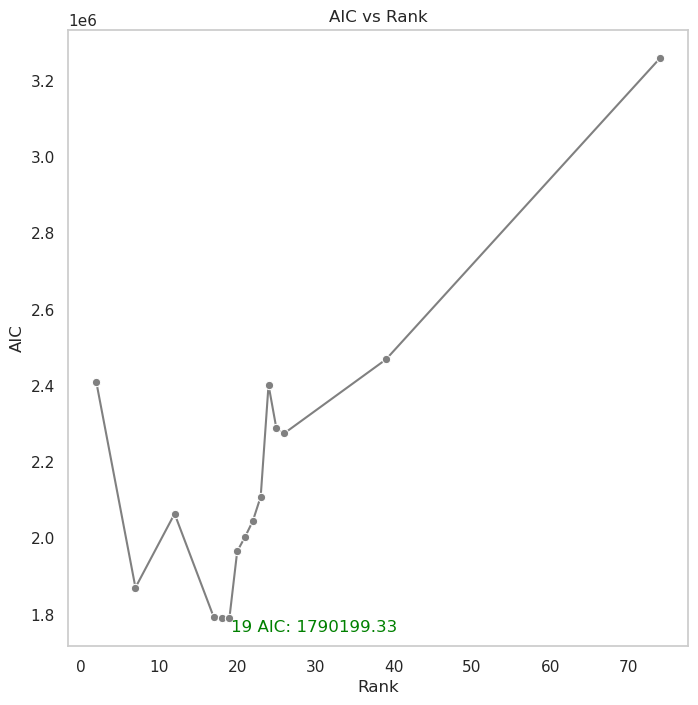

In [32]:
# Sort DataFrame by Rank to ensure lines connect in the correct order
df_metrics.sort_index(inplace=True)

# Set style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 8))
plot = sns.lineplot(x=df_metrics.index, y='AIC', data=df_metrics, sort=False, marker='o', linestyle='-', color='grey')

# Annotate each point with rank and F1 Score
for rank, row in df_metrics.iterrows():
    #plt.text(row['Recall'] + 0.01, row['Precision'], f'Rank: {rank}, F1: {row["F1 Score"]:.2f}', color='black')
    # plt.text(row['Recall'] - 0.005, row['Precision'], f'{rank}', color='navy')
    #plt.text(row['Recall'] - 0.005, row['Precision'] - 0.002, f'F1: {row["F1 Score"]:.2f}', color='red')
    
    # Annotate the highest accuracy value

    if rank == df_metrics.AIC.idxmin():
        plt.text(rank + .15, row['AIC'] - .02*row['AIC'], f'{rank} AIC: {df_metrics.AIC.min():.2f}', color='green')

# Plot labels and title
plt.xlabel('Rank')
plt.ylabel('AIC')
plt.title('AIC vs Rank')
plt.grid(False)
plt.savefig('../images/supplemental/reconstruction_metrics.svg', format='svg')
plt.show()


In [33]:
df_metrics.loc[[df_metrics['Recall'].idxmax()]]

,Precision,Recall,FPR,FNR,Specificity,Prevalence,Accuracy,F1 Score,BM,Prevalence Threshold,MCC,Jaccard Index,AIC,BIC
rank,,,,,,,,,,,,,,
19,0.954481,0.725288,0.018009,0.274712,0.981991,0.342396,0.894097,0.824249,0.707279,0.136127,0.764959,0.70104,1.790199e+06,4.368495e+06
